In [1]:
!pip install imutils

In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

### Helper Functions to extract the skin color from an image
Source: https://github.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color

In [3]:
def extractSkin(image):
    # Taking a copy of the image
    img =  image.copy()
    # Converting from BGR Colours Space to HSV
    img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img,lower_threshold,upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

    # Extracting skin from the threshold mask
    skin  =  cv2.bitwise_and(img,img,mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)

In [4]:
def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
    hasBlack = False
  
  # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

  
  # Quick lambda function to compare to lists
    compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
    # Check if the color is [0,0,0] that if it is black 
        if compare(color , [0,0,0]) == True:
      # delete the occurance
            del occurance_counter[x[0]]
      # remove the cluster 
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster,x[0],0)
            break
      
   
    return (occurance_counter,estimator_cluster,hasBlack)
    
    

In [5]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []


    #Check for Black
    hasBlack =False
  
  # If a mask has be applied, remove th black
    if hasThresholding == True:
    
        (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
        occurance_counter =  occurance
        estimator_cluster = cluster
        hasBlack = black
    
    else:
        occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values()) 
  
 
  # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):
    
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage= (x[1]/totalOccurance)

        #make the dictionay of the information
        colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

        # Add the dictionary to the list
        colorInformation.append(colorInfo)
    
      
    return colorInformation 

In [6]:

def extractDominantColor(image,number_of_colors=5,hasThresholding=False):
  
    if hasThresholding == True:
        number_of_colors +=1
  
  # Taking Copy of the image
    img = image.copy()
  
  # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  #Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
    return colorInformation
  
  

### Helper Function to convert RGB value to HSV
Source: https://www.w3resource.com/python-exercises/math/python-math-exercise-77.php

In [7]:
def rgb_to_hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v


### Finally, the function which calculates the difference in the Saturation in the 2 images

In [8]:
def findTan(color1,color2): # Color 1 is original image, and Color 2 is the image we want it to be compared with
    currentTan = color2[1] - color1[1]
    print("Difference Index = ",currentTan)
    if currentTan>-10 and currentTan<12 : print("Not a significant change in the color tone")
    elif currentTan>11 : print("Image 2 is tanned by an amount of ", currentTan)
    else: print("Image 1 a lighter shade by an amount of ", currentTan*(-1))

## Testing it on images

In [9]:
# Source of above functions = https://medium.com/datadriveninvestor/skin-segmentation-and-dominant-tone-color-extraction-fe158d24badf

image1 = cv2.imread('images/person_normal.jpg')
# Resize image to a width of 250
image1 = imutils.resize(image1,width=250)
skin1 = extractSkin(image1)
dominantColors1 = extractDominantColor(skin1,hasThresholding=True)

image2 = cv2.imread('images/person_tan.jpg')
# Resize image to a width of 250
image2 = imutils.resize(image2,width=250)
skin2 = extractSkin(image2)
dominantColors2 = extractDominantColor(skin2,hasThresholding=True)

In [10]:
n = dominantColors1[0]['color']
t = dominantColors2[0]['color']
normal = rgb_to_hsv(n[2],n[1],n[0])
tanned = rgb_to_hsv(t[2],t[1],t[0])

print('Normal HSV Code : ', normal)
print('Tanned HSV Code : ', tanned)

Normal HSV Code :  (231.09473632093383, 27.04323852092601, 71.59806517840285)
Tanned HSV Code :  (237.3360039216538, 52.6931209134915, 50.055939892386824)


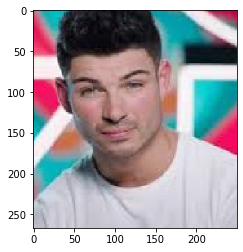

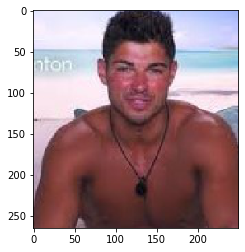

In [11]:
plt.imshow(cv2.cvtColor(image1,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
findTan(normal,tanned)

Difference Index =  25.649882392565488
Image 2 is tanned by an amount of  25.649882392565488
